<div style="border-left: 6px solid #00A86B; padding:20px; border-radius:10px; font-family:Arial, sans-serif; text-align:center; font-size:28px; font-weight:bold;">
  🔁 03 – Transfer Learning and Model Selection
</div>

<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📦 Import Libraries and Define Paths</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  <p style="font-size:18px;">This is the initial block of the rare species image classification project.</p>

  <p>In this section, we perform the following tasks:</p>

  <ul style="line-height: 1.6;">
    <li>📁 <strong>Import libraries</strong> for data manipulation (<code>pandas</code>), file paths (<code>pathlib</code>), and image processing (<code>PIL</code>).</li>
    <li>🖼️ <strong>Apply visual styling</strong> using <code>matplotlib</code> and <code>seaborn</code> to ensure clean and consistent plots.</li>
    <li>📂 <strong>Define the main project directories</strong>, including image folders and the metadata CSV file.</li>
    <li>✅ <strong>Automatic path validation</strong> to ensure all required files and directories exist.</li>
  </ul>

  <p>This setup provides a reliable foundation for safely loading and exploring the dataset.</p>
</div>


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB0, ResNet50, InceptionV3, DenseNet121, MobileNetV2, VGG16, ConvNeXtBase
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
from tabulate import tabulate
from PIL import Image
from IPython.display import display



In [2]:
PROJECT_ROOT = Path().resolve().parent

PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
MODELS_DIR = PROJECT_ROOT / 'models'
REPORTS_DIR = PROJECT_ROOT / 'reports'
OUTPUTS_DIR = PROJECT_ROOT / 'output'
LOGS_DIR = OUTPUTS_DIR / 'logs'
PREDICTIONS_DIR = OUTPUTS_DIR / 'predictions'
TRAIN_DIR = PROCESSED_DIR / 'train'
VAL_DIR = PROCESSED_DIR / 'val'
TEST_DIR = PROCESSED_DIR / 'test'

<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📦 Define Parameters</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  <p>In this section, we define the core parameters that will guide the training process of the model. These include the input image size, batch size, number of training epochs, and the directory structure of the dataset.</p>
  
  <p>Setting these values early ensures consistency across all steps and allows for easier adjustments when experimenting with different model architectures or datasets.</p>
</div>


In [3]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📂 Load and Prepare the Dataset</h2>
</div>

<div style="margin-left:60px; padding:10px; font-family:Arial, sans-serif; font-size:16px;"> 
  <p>This section is responsible for loading the processed dataset and preparing it for training and evaluation.</p>

  <p>Using <code>ImageDataGenerator</code>, the images are normalized (pixel values scaled between 0 and 1), and loaded in batches directly from the respective folders for:</p>

  <ul style="line-height: 1.6;">
    <li><strong>🟢 Training set</strong> — used to update model weights during learning</li>
    <li><strong>🟠 Validation set</strong> — used to monitor generalization and prevent overfitting</li>
    <li><strong>🔵 Test set</strong> — used for final evaluation after training</li>
  </ul>

  <p>The dataset is expected to be organized in subfolders where each folder represents one class label.</p>
</div>


In [4]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(TRAIN_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = datagen.flow_from_directory(VAL_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = datagen.flow_from_directory(TEST_DIR, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

NUM_CLASSES = train_generator.num_classes

Found 8462 images belonging to 202 classes.
Found 2157 images belonging to 202 classes.
Found 1199 images belonging to 202 classes.


<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📦 Baseline EfficientNetB0 Model</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  
</div>


In [5]:
def run_efficientnetb0_pipeline(train_gen, val_gen, test_gen, model_name="efficientnetb0_baseline", image_size=IMAGE_SIZE, epochs=EPOCHS):
    models_dir = MODELS_DIR
    logs_dir = LOGS_DIR
    predictions_dir = PREDICTIONS_DIR
    reports_dir = REPORTS_DIR
    figures_dir = reports_dir / "figures"
    for d in [models_dir, logs_dir, predictions_dir, figures_dir, reports_dir]:
        d.mkdir(parents=True, exist_ok=True)

    train_generator = train_gen
    val_generator = val_gen
    test_generator = test_gen

    num_classes = train_generator.num_classes

    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(image_size[0], image_size[1], 3), pooling='avg')
    base_model.trainable = False

    model = Sequential([
        base_model,
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')

    ])

    model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["accuracy"])

    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
    csv_logger = CSVLogger(logs_dir / f"{model_name}_training_log.csv", append=False)

    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[csv_logger, early_stop, reduce_lr])

    model_path = models_dir / f"{model_name}.h5"
    model_weights_path = models_dir / f"{model_name}.weights.h5"
    model.save(model_path)
    model.save_weights(model_weights_path)

    val_loss, val_acc = model.evaluate(val_generator)

    acc_fig_path = figures_dir / f"{model_name}_accuracy_plot.png"
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(acc_fig_path)
    plt.close()

    predictions = model.predict(test_generator)
    predicted_classes = predictions.argmax(axis=1)
    true_classes = test_generator.classes
    class_indices = test_generator.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    predicted_labels = [inv_class_indices[i] for i in predicted_classes]
    true_labels = [inv_class_indices[i] for i in true_classes]

    report = classification_report(true_classes, predicted_classes, target_names=list(class_indices.keys()), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_path = reports_dir / f"{model_name}_classification_report.csv"
    report_df.to_csv(report_path)

    heatmap_path = figures_dir / f"{model_name}_classification_report_heatmap_top20.png"
    filtered_df = report_df.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")
    top_20 = filtered_df.sort_values("support", ascending=False).head(20)
    plt.figure(figsize=(10, 8))
    sns.heatmap(top_20[["precision", "recall", "f1-score"]], annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, annot_kws={"size": 9})
    plt.title("Top 20 Classes – Classification Report", fontsize=14)
    plt.xlabel("Metrics", fontsize=12)
    plt.ylabel("Class", fontsize=12)
    plt.tight_layout()
    plt.savefig(heatmap_path)
    plt.close()

    top_labels = list(top_20.index)
    label_to_index = {name: i for i, name in enumerate(class_indices.keys())}
    top_indices = [label_to_index[l] for l in top_labels]
    filtered_true = [i for i in true_classes if i in top_indices]
    filtered_pred = [p for i, p in enumerate(predicted_classes) if true_classes[i] in top_indices]
    cm = confusion_matrix(filtered_true, filtered_pred, labels=top_indices)
    cm_labels = [list(class_indices.keys())[i] for i in top_indices]
    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=True)
    plt.title("Confusion Matrix – Top 20 Classes", fontsize=14)
    plt.tight_layout()
    cm_path = figures_dir / f"{model_name}_confusion_matrix_top20.png"
    plt.savefig(cm_path)
    plt.close()

    cm = confusion_matrix(true_classes, predicted_classes)
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_indices.keys()))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    full_cm_path = figures_dir / f"{model_name}_confusion_matrix.png"
    plt.savefig(full_cm_path)
    plt.close()

    filenames = test_generator.filenames
    results_df = pd.DataFrame({
        "filename": filenames,
        "true_label": true_labels,
        "predicted_label": predicted_labels
    })
    pred_path = predictions_dir / f"{model_name}_predictions.csv"
    results_df.to_csv(pred_path, index=False)

    return {
        "model_path": model_path,
        "log_path": logs_dir / f"{model_name}_training_log.csv",
        "report_path": report_path,
        "heatmap_path": heatmap_path,
        "confusion_matrix": full_cm_path,
        "predictions_path": pred_path,
        "accuracy_plot": acc_fig_path,
        "val_accuracy": val_acc
    }

In [6]:
results_efficientnetb0 = run_efficientnetb0_pipeline(
    train_gen=train_generator,
    val_gen=val_generator,
    test_gen=test_generator,
    model_name="efficientnetb0_baseline"
)

print("📦 EfficientNetB0 – Results Summary:\n")
print(f"📁 Model saved at:              {results_efficientnetb0['model_path']}")
print(f"📄 Training log:                {results_efficientnetb0['log_path']}")
print(f"📊 Classification report (CSV): {results_efficientnetb0['report_path']}")
print(f"🧯 Report heatmap (Top 20):     {results_efficientnetb0['heatmap_path']}")
print(f"📉 Confusion matrix (full):     {results_efficientnetb0['confusion_matrix']}")
print(f"📈 Accuracy plot:               {results_efficientnetb0['accuracy_plot']}")
print(f"📑 Predictions CSV:             {results_efficientnetb0['predictions_path']}")
print(f"✅ Final validation accuracy:   {results_efficientnetb0['val_accuracy']:.2%}")


c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.0162 - loss: 5.3187 - val_accuracy: 0.0311 - val_loss: 5.2238 - learning_rate: 5.0000e-04
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 99s 372ms/step - accuracy: 0.0363 - loss: 5.1098 - val_accuracy: 0.0389 - val_loss: 5.1607 - learning_rate: 5.0000e-04
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 97s 367ms/step - accuracy: 0.0329 - loss: 5.0783 - val_accuracy: 0.0389 - val_loss: 5.0399 - learning_rate: 5.0000e-04
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 103s 387ms/step - accuracy: 0.0296 - loss: 5.0460 - val_accuracy: 0.0468 - val_loss: 4.9727 - learning_rate: 5.0000e-04
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 126s 474ms/step - accuracy: 0.0327 - loss: 5.0004 - val_accuracy: 0.0510 - val_loss: 4.9483 - learning_rate: 5.0000e-04
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 84s 316ms/step - accuracy: 0.0377 - loss: 4.9989 - val_accuracy: 0.0403 - val_loss: 4.9314 - learning_rate: 5.0000e-04
Epoch 7/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 86s 32

68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.0486 - loss: 4.8880
38/38 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step


c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

📦 EfficientNetB0 – Results Summary:

📁 Model saved at:              D:\Repositories\DL_EOLP\models\efficientnetb0_baseline.h5
📄 Training log:                D:\Repositories\DL_EOLP\output\logs\efficientnetb0_baseline_training_log.csv
📊 Classification report (CSV): D:\Repositories\DL_EOLP\reports\efficientnetb0_baseline_classification_report.csv
🧯 Report heatmap (Top 20):     D:\Repositories\DL_EOLP\reports\figures\efficientnetb0_baseline_classification_report_heatmap_top20.png
📉 Confusion matrix (full):     D:\Repositories\DL_EOLP\reports\figures\efficientnetb0_baseline_confusion_matrix.png
📈 Accuracy plot:               D:\Repositories\DL_EOLP\reports\figures\efficientnetb0_baseline_accuracy_plot.png
📑 Predictions CSV:             D:\Repositories\DL_EOLP\output\predictions\efficientnetb0_baseline_predictions.csv
✅ Final validation accuracy:   5.01%


<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📦 Baseline ResNet50 Model</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  
</div>


In [7]:
def run_resnet50_pipeline(train_gen, val_gen, test_gen, model_name="resnet50_baseline", image_size=IMAGE_SIZE, epochs=EPOCHS):
    models_dir = MODELS_DIR
    logs_dir = LOGS_DIR
    predictions_dir = PREDICTIONS_DIR
    reports_dir = REPORTS_DIR
    figures_dir = reports_dir / "figures"
    for d in [models_dir, logs_dir, predictions_dir, figures_dir, reports_dir]:
        d.mkdir(parents=True, exist_ok=True)

    train_generator = train_gen
    val_generator = val_gen
    test_generator = test_gen

    num_classes = train_generator.num_classes

    base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(image_size[0], image_size[1], 3), pooling='avg')
    base_model.trainable = False

    model = Sequential([
        base_model,
        BatchNormalization(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["accuracy"])

    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
    csv_logger = CSVLogger(logs_dir / f"{model_name}_training_log.csv", append=False)

    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[csv_logger, early_stop, reduce_lr])

    model_path = models_dir / f"{model_name}.h5"
    model_weights_path = models_dir / f"{model_name}.weights.h5"
    model.save(model_path)
    model.save_weights(model_weights_path)

    val_loss, val_acc = model.evaluate(val_generator)

    acc_fig_path = figures_dir / f"{model_name}_accuracy_plot.png"
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(acc_fig_path)
    plt.close()

    predictions = model.predict(test_generator)
    predicted_classes = predictions.argmax(axis=1)
    true_classes = test_generator.classes
    class_indices = test_generator.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    predicted_labels = [inv_class_indices[i] for i in predicted_classes]
    true_labels = [inv_class_indices[i] for i in true_classes]

    report = classification_report(true_classes, predicted_classes, target_names=list(class_indices.keys()), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_path = reports_dir / f"{model_name}_classification_report.csv"
    report_df.to_csv(report_path)

    heatmap_path = figures_dir / f"{model_name}_classification_report_heatmap_top20.png"
    filtered_df = report_df.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")
    top_20 = filtered_df.sort_values("support", ascending=False).head(20)
    plt.figure(figsize=(10, 8))
    sns.heatmap(top_20[["precision", "recall", "f1-score"]], annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, annot_kws={"size": 9})
    plt.title("Top 20 Classes – Classification Report", fontsize=14)
    plt.xlabel("Metrics", fontsize=12)
    plt.ylabel("Class", fontsize=12)
    plt.tight_layout()
    plt.savefig(heatmap_path)
    plt.close()

    top_labels = list(top_20.index)
    label_to_index = {name: i for i, name in enumerate(class_indices.keys())}
    top_indices = [label_to_index[l] for l in top_labels]
    filtered_true = [i for i in true_classes if i in top_indices]
    filtered_pred = [p for i, p in enumerate(predicted_classes) if true_classes[i] in top_indices]
    cm = confusion_matrix(filtered_true, filtered_pred, labels=top_indices)
    cm_labels = [list(class_indices.keys())[i] for i in top_indices]
    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=True)
    plt.title("Confusion Matrix – Top 20 Classes", fontsize=14)
    plt.tight_layout()
    cm_path = figures_dir / f"{model_name}_confusion_matrix_top20.png"
    plt.savefig(cm_path)
    plt.close()

    cm = confusion_matrix(true_classes, predicted_classes)
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_indices.keys()))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    full_cm_path = figures_dir / f"{model_name}_confusion_matrix.png"
    plt.savefig(full_cm_path)
    plt.close()

    filenames = test_generator.filenames
    results_df = pd.DataFrame({
        "filename": filenames,
        "true_label": true_labels,
        "predicted_label": predicted_labels
    })
    pred_path = predictions_dir / f"{model_name}_predictions.csv"
    results_df.to_csv(pred_path, index=False)

    return {
        "model_path": model_path,
        "log_path": logs_dir / f"{model_name}_training_log.csv",
        "report_path": report_path,
        "heatmap_path": heatmap_path,
        "confusion_matrix": full_cm_path,
        "predictions_path": pred_path,
        "accuracy_plot": acc_fig_path,
        "val_accuracy": val_acc
    }

In [8]:
results_resnet50 = run_resnet50_pipeline(
    train_gen=train_generator,
    val_gen=val_generator,
    test_gen=test_generator
)

print("📦 ResNet50 – Results Summary:\n")
print(f"📁 Model saved at:              {results_resnet50['model_path']}")
print(f"📄 Training log:                {results_resnet50['log_path']}")
print(f"📊 Classification report (CSV): {results_resnet50['report_path']}")
print(f"🧯 Report heatmap (Top 20):     {results_resnet50['heatmap_path']}")
print(f"📉 Confusion matrix (full):     {results_resnet50['confusion_matrix']}")
print(f"📈 Accuracy plot:               {results_resnet50['accuracy_plot']}")
print(f"📑 Predictions CSV:             {results_resnet50['predictions_path']}")
print(f"✅ Final validation accuracy:   {results_resnet50['val_accuracy']:.2%}")


Epoch 1/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 136s 491ms/step - accuracy: 0.0357 - loss: 5.2126 - val_accuracy: 0.0839 - val_loss: 4.9729 - learning_rate: 5.0000e-04
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 136s 512ms/step - accuracy: 0.0716 - loss: 4.7650 - val_accuracy: 0.1043 - val_loss: 4.6617 - learning_rate: 5.0000e-04
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 137s 519ms/step - accuracy: 0.0951 - loss: 4.5609 - val_accuracy: 0.1242 - val_loss: 4.4691 - learning_rate: 5.0000e-04
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 138s 521ms/step - accuracy: 0.1115 - loss: 4.3910 - val_accuracy: 0.1229 - val_loss: 4.4279 - learning_rate: 5.0000e-04
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 141s 534ms/step - accuracy: 0.1216 - loss: 4.2655 - val_accuracy: 0.1280 - val_loss: 4.3865 - learning_rate: 5.0000e-04
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 137s 517ms/step - accuracy: 0.1418 - loss: 4.1557 - val_accuracy: 0.1303 - val_loss: 4.3173 - learning_rate: 5.0000e-04
Epoch 7/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 

68/68 ━━━━━━━━━━━━━━━━━━━━ 29s 428ms/step - accuracy: 0.1431 - loss: 4.2438
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 863ms/step


c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

📦 ResNet50 – Results Summary:

📁 Model saved at:              D:\Repositories\DL_EOLP\models\resnet50_baseline.h5
📄 Training log:                D:\Repositories\DL_EOLP\output\logs\resnet50_baseline_training_log.csv
📊 Classification report (CSV): D:\Repositories\DL_EOLP\reports\resnet50_baseline_classification_report.csv
🧯 Report heatmap (Top 20):     D:\Repositories\DL_EOLP\reports\figures\resnet50_baseline_classification_report_heatmap_top20.png
📉 Confusion matrix (full):     D:\Repositories\DL_EOLP\reports\figures\resnet50_baseline_confusion_matrix.png
📈 Accuracy plot:               D:\Repositories\DL_EOLP\reports\figures\resnet50_baseline_accuracy_plot.png
📑 Predictions CSV:             D:\Repositories\DL_EOLP\output\predictions\resnet50_baseline_predictions.csv
✅ Final validation accuracy:   14.74%


<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📦 Baseline DenseNet121 Model</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  
</div>


In [9]:
def run_densenet121_pipeline(train_gen, val_gen, test_gen, model_name="densenet121_baseline", image_size=IMAGE_SIZE, epochs=EPOCHS):
    models_dir = MODELS_DIR
    logs_dir = LOGS_DIR
    predictions_dir = PREDICTIONS_DIR
    reports_dir = REPORTS_DIR
    figures_dir = reports_dir / "figures"
    for d in [models_dir, logs_dir, predictions_dir, figures_dir, reports_dir]:
        d.mkdir(parents=True, exist_ok=True)

    train_generator = train_gen
    val_generator = val_gen
    test_generator = test_gen

    num_classes = train_generator.num_classes

    base_model = DenseNet121(include_top=False, weights="imagenet", input_shape=(image_size[0], image_size[1], 3), pooling='avg')
    base_model.trainable = False

    model = Sequential([
        base_model,
        BatchNormalization(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["accuracy"])

    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
    csv_logger = CSVLogger(logs_dir / f"{model_name}_training_log.csv", append=False)

    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[csv_logger, early_stop, reduce_lr])

    model_path = models_dir / f"{model_name}.h5"
    model_weights_path = models_dir / f"{model_name}.weights.h5"
    model.save(model_path)
    model.save_weights(model_weights_path)

    val_loss, val_acc = model.evaluate(val_generator)

    acc_fig_path = figures_dir / f"{model_name}_accuracy_plot.png"
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(acc_fig_path)
    plt.close()

    predictions = model.predict(test_generator)
    predicted_classes = predictions.argmax(axis=1)
    true_classes = test_generator.classes
    class_indices = test_generator.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    predicted_labels = [inv_class_indices[i] for i in predicted_classes]
    true_labels = [inv_class_indices[i] for i in true_classes]

    report = classification_report(true_classes, predicted_classes, target_names=list(class_indices.keys()), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_path = reports_dir / f"{model_name}_classification_report.csv"
    report_df.to_csv(report_path)

    heatmap_path = figures_dir / f"{model_name}_classification_report_heatmap_top20.png"
    filtered_df = report_df.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")
    top_20 = filtered_df.sort_values("support", ascending=False).head(20)
    plt.figure(figsize=(10, 8))
    sns.heatmap(top_20[["precision", "recall", "f1-score"]], annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, annot_kws={"size": 9})
    plt.title("Top 20 Classes – Classification Report", fontsize=14)
    plt.xlabel("Metrics", fontsize=12)
    plt.ylabel("Class", fontsize=12)
    plt.tight_layout()
    plt.savefig(heatmap_path)
    plt.close()

    top_labels = list(top_20.index)
    label_to_index = {name: i for i, name in enumerate(class_indices.keys())}
    top_indices = [label_to_index[l] for l in top_labels]
    filtered_true = [i for i in true_classes if i in top_indices]
    filtered_pred = [p for i, p in enumerate(predicted_classes) if true_classes[i] in top_indices]
    cm = confusion_matrix(filtered_true, filtered_pred, labels=top_indices)
    cm_labels = [list(class_indices.keys())[i] for i in top_indices]
    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=True)
    plt.title("Confusion Matrix – Top 20 Classes", fontsize=14)
    plt.tight_layout()
    cm_path = figures_dir / f"{model_name}_confusion_matrix_top20.png"
    plt.savefig(cm_path)
    plt.close()

    cm = confusion_matrix(true_classes, predicted_classes)
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_indices.keys()))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    full_cm_path = figures_dir / f"{model_name}_confusion_matrix.png"
    plt.savefig(full_cm_path)
    plt.close()

    filenames = test_generator.filenames
    results_df = pd.DataFrame({
        "filename": filenames,
        "true_label": true_labels,
        "predicted_label": predicted_labels
    })
    pred_path = predictions_dir / f"{model_name}_predictions.csv"
    results_df.to_csv(pred_path, index=False)

    return {
        "model_path": model_path,
        "log_path": logs_dir / f"{model_name}_training_log.csv",
        "report_path": report_path,
        "heatmap_path": heatmap_path,
        "confusion_matrix": full_cm_path,
        "predictions_path": pred_path,
        "accuracy_plot": acc_fig_path,
        "val_accuracy": val_acc
    }

In [10]:
results_densenet121 = run_densenet121_pipeline(
    train_gen=train_generator,
    val_gen=val_generator,
    test_gen=test_generator,
    model_name="densenet121_baseline"
)

print("📦 DenseNet121 – Results Summary:\n")
print(f"📁 Model saved at:              {results_densenet121['model_path']}")
print(f"📄 Training log:                {results_densenet121['log_path']}")
print(f"📊 Classification report (CSV): {results_densenet121['report_path']}")
print(f"🧯 Report heatmap (Top 20):     {results_densenet121['heatmap_path']}")
print(f"📉 Confusion matrix (full):     {results_densenet121['confusion_matrix']}")
print(f"📈 Accuracy plot:               {results_densenet121['accuracy_plot']}")
print(f"📑 Predictions CSV:             {results_densenet121['predictions_path']}")
print(f"✅ Final validation accuracy:   {results_densenet121['val_accuracy']:.2%}")

Epoch 1/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 145s 507ms/step - accuracy: 0.0902 - loss: 4.9419 - val_accuracy: 0.1312 - val_loss: 5.0568 - learning_rate: 5.0000e-04
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 136s 515ms/step - accuracy: 0.2633 - loss: 3.3822 - val_accuracy: 0.0501 - val_loss: 5.2180 - learning_rate: 5.0000e-04
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 136s 512ms/step - accuracy: 0.3693 - loss: 2.6006 - val_accuracy: 0.0547 - val_loss: 5.1831 - learning_rate: 5.0000e-04
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.4474 - loss: 2.1716
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
265/265 ━━━━━━━━━━━━━━━━━━━━ 134s 505ms/step - accuracy: 0.4474 - loss: 2.1715 - val_accuracy: 0.0631 - val_loss: 5.1714 - learning_rate: 5.0000e-04
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 134s 505ms/step - accuracy: 0.5068 - loss: 1.8607 - val_accuracy: 0.0663 - val_loss: 5.1501 - learning_rate: 2.5000e-04
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 135s 51

68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 530ms/step - accuracy: 0.1342 - loss: 5.0537
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 909ms/step


c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

📦 DenseNet121 – Results Summary:

📁 Model saved at:              D:\Repositories\DL_EOLP\models\densenet121_baseline.h5
📄 Training log:                D:\Repositories\DL_EOLP\output\logs\densenet121_baseline_training_log.csv
📊 Classification report (CSV): D:\Repositories\DL_EOLP\reports\densenet121_baseline_classification_report.csv
🧯 Report heatmap (Top 20):     D:\Repositories\DL_EOLP\reports\figures\densenet121_baseline_classification_report_heatmap_top20.png
📉 Confusion matrix (full):     D:\Repositories\DL_EOLP\reports\figures\densenet121_baseline_confusion_matrix.png
📈 Accuracy plot:               D:\Repositories\DL_EOLP\reports\figures\densenet121_baseline_accuracy_plot.png
📑 Predictions CSV:             D:\Repositories\DL_EOLP\output\predictions\densenet121_baseline_predictions.csv
✅ Final validation accuracy:   13.12%


<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📦 Baseline MobileNetV2 Model</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  
</div>


In [11]:
def run_mobilenetv2_pipeline(train_gen, val_gen, test_gen, model_name="mobilenetv2_baseline", image_size=IMAGE_SIZE, epochs=EPOCHS):
    models_dir = MODELS_DIR
    logs_dir = LOGS_DIR
    predictions_dir = PREDICTIONS_DIR
    reports_dir = REPORTS_DIR
    figures_dir = reports_dir / "figures"
    for d in [models_dir, logs_dir, predictions_dir, figures_dir, reports_dir]:
        d.mkdir(parents=True, exist_ok=True)

    train_generator = train_gen
    val_generator = val_gen
    test_generator = test_gen

    num_classes = train_generator.num_classes

    base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(image_size[0], image_size[1], 3), pooling='avg')
    base_model.trainable = False

    model = Sequential([
        base_model,
        BatchNormalization(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["accuracy"])

    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
    csv_logger = CSVLogger(logs_dir / f"{model_name}_training_log.csv", append=False)

    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[csv_logger, early_stop, reduce_lr])

    model_path = models_dir / f"{model_name}.h5"
    model_weights_path = models_dir / f"{model_name}.weights.h5"
    model.save(model_path)
    model.save_weights(model_weights_path)

    val_loss, val_acc = model.evaluate(val_generator)

    acc_fig_path = figures_dir / f"{model_name}_accuracy_plot.png"
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(acc_fig_path)
    plt.close()

    predictions = model.predict(test_generator)
    predicted_classes = predictions.argmax(axis=1)
    true_classes = test_generator.classes
    class_indices = test_generator.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    predicted_labels = [inv_class_indices[i] for i in predicted_classes]
    true_labels = [inv_class_indices[i] for i in true_classes]

    report = classification_report(true_classes, predicted_classes, target_names=list(class_indices.keys()), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_path = reports_dir / f"{model_name}_classification_report.csv"
    report_df.to_csv(report_path)

    heatmap_path = figures_dir / f"{model_name}_classification_report_heatmap_top20.png"
    filtered_df = report_df.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")
    top_20 = filtered_df.sort_values("support", ascending=False).head(20)
    plt.figure(figsize=(10, 8))
    sns.heatmap(top_20[["precision", "recall", "f1-score"]], annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, annot_kws={"size": 9})
    plt.title("Top 20 Classes – Classification Report", fontsize=14)
    plt.xlabel("Metrics", fontsize=12)
    plt.ylabel("Class", fontsize=12)
    plt.tight_layout()
    plt.savefig(heatmap_path)
    plt.close()

    top_labels = list(top_20.index)
    label_to_index = {name: i for i, name in enumerate(class_indices.keys())}
    top_indices = [label_to_index[l] for l in top_labels]
    filtered_true = [i for i in true_classes if i in top_indices]
    filtered_pred = [p for i, p in enumerate(predicted_classes) if true_classes[i] in top_indices]
    cm = confusion_matrix(filtered_true, filtered_pred, labels=top_indices)
    cm_labels = [list(class_indices.keys())[i] for i in top_indices]
    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=True)
    plt.title("Confusion Matrix – Top 20 Classes", fontsize=14)
    plt.tight_layout()
    cm_path = figures_dir / f"{model_name}_confusion_matrix_top20.png"
    plt.savefig(cm_path)
    plt.close()

    cm = confusion_matrix(true_classes, predicted_classes)
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_indices.keys()))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    full_cm_path = figures_dir / f"{model_name}_confusion_matrix.png"
    plt.savefig(full_cm_path)
    plt.close()

    filenames = test_generator.filenames
    results_df = pd.DataFrame({
        "filename": filenames,
        "true_label": true_labels,
        "predicted_label": predicted_labels
    })
    pred_path = predictions_dir / f"{model_name}_predictions.csv"
    results_df.to_csv(pred_path, index=False)

    return {
        "model_path": model_path,
        "log_path": logs_dir / f"{model_name}_training_log.csv",
        "report_path": report_path,
        "heatmap_path": heatmap_path,
        "confusion_matrix": full_cm_path,
        "predictions_path": pred_path,
        "accuracy_plot": acc_fig_path,
        "val_accuracy": val_acc
    }

In [12]:
results_mobilenetv2 = run_mobilenetv2_pipeline(
    train_gen=train_generator,
    val_gen=val_generator,
    test_gen=test_generator,
    model_name="mobilenetv2_baseline"
)

print("📦 MobileNetV2 – Results Summary:\n")
print(f"📁 Model saved at:              {results_mobilenetv2['model_path']}")
print(f"📄 Training log:                {results_mobilenetv2['log_path']}")
print(f"📊 Classification report (CSV): {results_mobilenetv2['report_path']}")
print(f"🧯 Report heatmap (Top 20):     {results_mobilenetv2['heatmap_path']}")
print(f"📉 Confusion matrix (full):     {results_mobilenetv2['confusion_matrix']}")
print(f"📈 Accuracy plot:               {results_mobilenetv2['accuracy_plot']}")
print(f"📑 Predictions CSV:             {results_mobilenetv2['predictions_path']}")
print(f"✅ Final validation accuracy:   {results_mobilenetv2['val_accuracy']:.2%}")


Epoch 1/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 93s 329ms/step - accuracy: 0.0898 - loss: 5.0344 - val_accuracy: 0.3092 - val_loss: 3.3931 - learning_rate: 5.0000e-04
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 79s 299ms/step - accuracy: 0.2894 - loss: 3.3035 - val_accuracy: 0.4256 - val_loss: 2.4694 - learning_rate: 5.0000e-04
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 72s 270ms/step - accuracy: 0.3865 - loss: 2.5694 - val_accuracy: 0.4659 - val_loss: 2.2095 - learning_rate: 5.0000e-04
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 75s 284ms/step - accuracy: 0.4447 - loss: 2.1744 - val_accuracy: 0.5067 - val_loss: 2.0344 - learning_rate: 5.0000e-04
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 66s 250ms/step - accuracy: 0.5233 - loss: 1.8487 - val_accuracy: 0.5151 - val_loss: 1.9561 - learning_rate: 5.0000e-04
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 65s 245ms/step - accuracy: 0.5515 - loss: 1.6832 - val_accuracy: 0.5243 - val_loss: 1.9006 - learning_rate: 5.0000e-04
Epoch 7/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 60s 22

68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - accuracy: 0.5436 - loss: 1.8915
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 723ms/step


c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

📦 MobileNetV2 – Results Summary:

📁 Model saved at:              D:\Repositories\DL_EOLP\models\mobilenetv2_baseline.h5
📄 Training log:                D:\Repositories\DL_EOLP\output\logs\mobilenetv2_baseline_training_log.csv
📊 Classification report (CSV): D:\Repositories\DL_EOLP\reports\mobilenetv2_baseline_classification_report.csv
🧯 Report heatmap (Top 20):     D:\Repositories\DL_EOLP\reports\figures\mobilenetv2_baseline_classification_report_heatmap_top20.png
📉 Confusion matrix (full):     D:\Repositories\DL_EOLP\reports\figures\mobilenetv2_baseline_confusion_matrix.png
📈 Accuracy plot:               D:\Repositories\DL_EOLP\reports\figures\mobilenetv2_baseline_accuracy_plot.png
📑 Predictions CSV:             D:\Repositories\DL_EOLP\output\predictions\mobilenetv2_baseline_predictions.csv
✅ Final validation accuracy:   54.29%


<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📦 Baseline VGG16 Model</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  
</div>


In [13]:
def run_vgg16_pipeline(train_gen, val_gen, test_gen, model_name="vgg16_baseline", image_size=IMAGE_SIZE, epochs=EPOCHS):
    models_dir = MODELS_DIR
    logs_dir = LOGS_DIR
    predictions_dir = PREDICTIONS_DIR
    reports_dir = REPORTS_DIR
    figures_dir = reports_dir / "figures"
    for d in [models_dir, logs_dir, predictions_dir, figures_dir, reports_dir]:
        d.mkdir(parents=True, exist_ok=True)

    train_generator = train_gen
    val_generator = val_gen
    test_generator = test_gen

    num_classes = train_generator.num_classes

    base_model = VGG16(include_top=False, weights="imagenet", input_shape=(image_size[0], image_size[1], 3), pooling='avg')
    base_model.trainable = False

    model = Sequential([
        base_model,
        BatchNormalization(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["accuracy"])

    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
    csv_logger = CSVLogger(logs_dir / f"{model_name}_training_log.csv", append=False)

    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[csv_logger, early_stop, reduce_lr])

    model_path = models_dir / f"{model_name}.h5"
    model_weights_path = models_dir / f"{model_name}.weights.h5"
    model.save(model_path)
    model.save_weights(model_weights_path)

    val_loss, val_acc = model.evaluate(val_generator)

    acc_fig_path = figures_dir / f"{model_name}_accuracy_plot.png"
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(acc_fig_path)
    plt.close()

    predictions = model.predict(test_generator)
    predicted_classes = predictions.argmax(axis=1)
    true_classes = test_generator.classes
    class_indices = test_generator.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    predicted_labels = [inv_class_indices[i] for i in predicted_classes]
    true_labels = [inv_class_indices[i] for i in true_classes]

    report = classification_report(true_classes, predicted_classes, target_names=list(class_indices.keys()), output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_path = reports_dir / f"{model_name}_classification_report.csv"
    report_df.to_csv(report_path)

    heatmap_path = figures_dir / f"{model_name}_classification_report_heatmap_top20.png"
    filtered_df = report_df.drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")
    top_20 = filtered_df.sort_values("support", ascending=False).head(20)
    plt.figure(figsize=(10, 8))
    sns.heatmap(top_20[["precision", "recall", "f1-score"]], annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, annot_kws={"size": 9})
    plt.title("Top 20 Classes – Classification Report", fontsize=14)
    plt.xlabel("Metrics", fontsize=12)
    plt.ylabel("Class", fontsize=12)
    plt.tight_layout()
    plt.savefig(heatmap_path)
    plt.close()

    top_labels = list(top_20.index)
    label_to_index = {name: i for i, name in enumerate(class_indices.keys())}
    top_indices = [label_to_index[l] for l in top_labels]
    filtered_true = [i for i in true_classes if i in top_indices]
    filtered_pred = [p for i, p in enumerate(predicted_classes) if true_classes[i] in top_indices]
    cm = confusion_matrix(filtered_true, filtered_pred, labels=top_indices)
    cm_labels = [list(class_indices.keys())[i] for i in top_indices]
    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=True)
    plt.title("Confusion Matrix – Top 20 Classes", fontsize=14)
    plt.tight_layout()
    cm_path = figures_dir / f"{model_name}_confusion_matrix_top20.png"
    plt.savefig(cm_path)
    plt.close()

    cm = confusion_matrix(true_classes, predicted_classes)
    fig, ax = plt.subplots(figsize=(20, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_indices.keys()))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    full_cm_path = figures_dir / f"{model_name}_confusion_matrix.png"
    plt.savefig(full_cm_path)
    plt.close()

    filenames = test_generator.filenames
    results_df = pd.DataFrame({
        "filename": filenames,
        "true_label": true_labels,
        "predicted_label": predicted_labels
    })
    pred_path = predictions_dir / f"{model_name}_predictions.csv"
    results_df.to_csv(pred_path, index=False)

    return {
        "model_path": model_path,
        "log_path": logs_dir / f"{model_name}_training_log.csv",
        "report_path": report_path,
        "heatmap_path": heatmap_path,
        "confusion_matrix": full_cm_path,
        "predictions_path": pred_path,
        "accuracy_plot": acc_fig_path,
        "val_accuracy": val_acc
    }

In [14]:
results_vgg16 = run_vgg16_pipeline(
    train_gen=train_generator,
    val_gen=val_generator,
    test_gen=test_generator,
    model_name="vgg16_baseline"
)

print("📦 VGG16 – Results Summary:\n")
print(f"📁 Model saved at:              {results_vgg16['model_path']}")
print(f"📄 Training log:                {results_vgg16['log_path']}")
print(f"📊 Classification report (CSV): {results_vgg16['report_path']}")
print(f"🧯 Report heatmap (Top 20):     {results_vgg16['heatmap_path']}")
print(f"📉 Confusion matrix (full):     {results_vgg16['confusion_matrix']}")
print(f"📈 Accuracy plot:               {results_vgg16['accuracy_plot']}")
print(f"📑 Predictions CSV:             {results_vgg16['predictions_path']}")
print(f"✅ Final validation accuracy:   {results_vgg16['val_accuracy']:.2%}")

Epoch 1/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.0455 - loss: 5.1671 - val_accuracy: 0.1655 - val_loss: 4.7406 - learning_rate: 5.0000e-04
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.1587 - loss: 4.2268 - val_accuracy: 0.2369 - val_loss: 3.7155 - learning_rate: 5.0000e-04
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.2137 - loss: 3.6614 - val_accuracy: 0.2847 - val_loss: 3.2424 - learning_rate: 5.0000e-04
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.2574 - loss: 3.3097 - val_accuracy: 0.3255 - val_loss: 3.0050 - learning_rate: 5.0000e-04
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.3113 - loss: 2.9878 - val_accuracy: 0.3505 - val_loss: 2.8440 - learning_rate: 5.0000e-04
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.3289 - loss: 2.7887 - val_accuracy: 0.3574 - val_loss: 2.7832 - learning_rate: 5.0000e-04
Epoch 7/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - acc

68/68 ━━━━━━━━━━━━━━━━━━━━ 65s 954ms/step - accuracy: 0.4303 - loss: 2.5556
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 996ms/step


c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

📦 VGG16 – Results Summary:

📁 Model saved at:              D:\Repositories\DL_EOLP\models\vgg16_baseline.h5
📄 Training log:                D:\Repositories\DL_EOLP\output\logs\vgg16_baseline_training_log.csv
📊 Classification report (CSV): D:\Repositories\DL_EOLP\reports\vgg16_baseline_classification_report.csv
🧯 Report heatmap (Top 20):     D:\Repositories\DL_EOLP\reports\figures\vgg16_baseline_classification_report_heatmap_top20.png
📉 Confusion matrix (full):     D:\Repositories\DL_EOLP\reports\figures\vgg16_baseline_confusion_matrix.png
📈 Accuracy plot:               D:\Repositories\DL_EOLP\reports\figures\vgg16_baseline_accuracy_plot.png
📑 Predictions CSV:             D:\Repositories\DL_EOLP\output\predictions\vgg16_baseline_predictions.csv
✅ Final validation accuracy:   41.17%


<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📦 Resume Models Validation Accuracy</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  
</div>


In [15]:
models_summary = [
    {"Model": "EfficientNetB0", "Val Accuracy": results_efficientnetb0['val_accuracy']},
    {"Model": "ResNet50", "Val Accuracy": results_resnet50['val_accuracy']},
    {"Model": "DenseNet121", "Val Accuracy": results_densenet121['val_accuracy']},
    {"Model": "MobileNetV2", "Val Accuracy": results_mobilenetv2['val_accuracy']},
    {"Model": "VGG16", "Val Accuracy": results_vgg16['val_accuracy']}
]

summary_df = pd.DataFrame(models_summary)
summary_df = summary_df.sort_values(by="Val Accuracy", ascending=False).reset_index(drop=True)

summary_df.to_csv(REPORTS_DIR / "model_comparison_summary.csv", index=False)

print(tabulate(summary_df.head(), headers="keys", tablefmt="fancy_grid", showindex=False, floatfmt=".2f"))

╒════════════════╤════════════════╕
│ Model          │   Val Accuracy │
╞════════════════╪════════════════╡
│ MobileNetV2    │           0.54 │
├────────────────┼────────────────┤
│ VGG16          │           0.41 │
├────────────────┼────────────────┤
│ ResNet50       │           0.15 │
├────────────────┼────────────────┤
│ DenseNet121    │           0.13 │
├────────────────┼────────────────┤
│ EfficientNetB0 │           0.05 │
╘════════════════╧════════════════╛


C:\Users\Tiago Pedro\AppData\Local\Temp\ipykernel_18624\3642737106.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="Val Accuracy", y="Model", palette="crest")


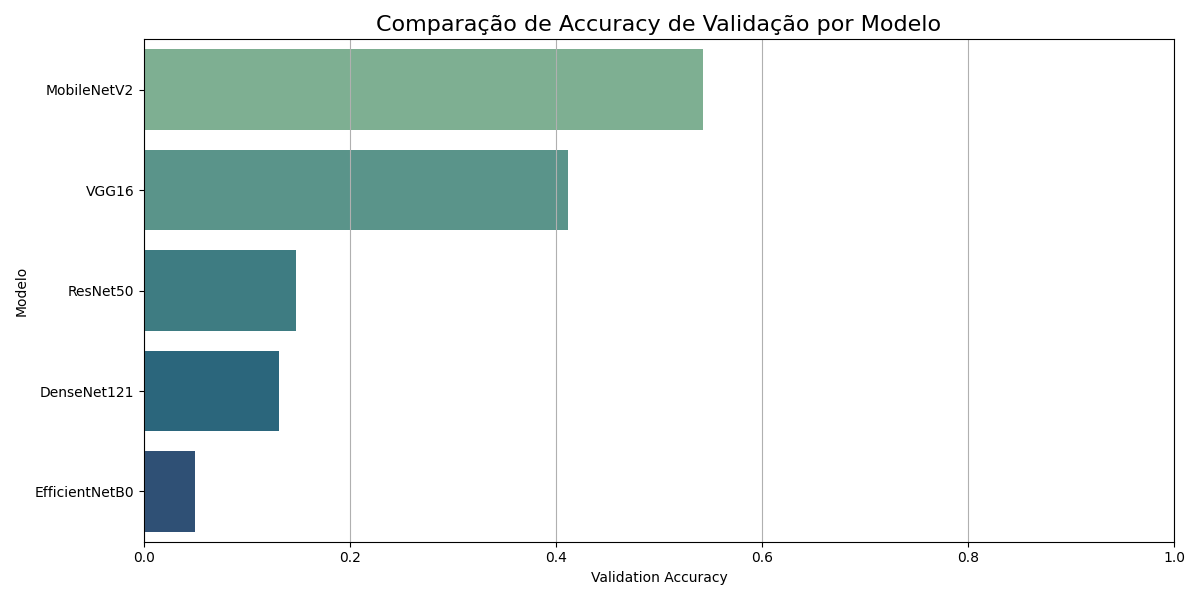

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(data=summary_df, x="Val Accuracy", y="Model", palette="crest")
plt.title("Comparação de Accuracy de Validação por Modelo", fontsize=16)
plt.xlabel("Validation Accuracy")
plt.ylabel("Modelo")
plt.xlim(0, 1)
plt.grid(axis='x')
plt.tight_layout()

plot_path = REPORTS_DIR / 'figures' / "model_comparison_accuracy.png"
plt.savefig(plot_path)
plt.close()

image = Image.open(REPORTS_DIR / 'figures' / "model_comparison_accuracy.png")
display(image)